# Solar Modeling
- Get 2006 solar plant power generation data here: https://www.nrel.gov/grid/solar-power-data.
- Use it to simulate different scenarios of load and battery capacities.
- Optimize battery and solar array size to minimize overall system cost. Takes <10min to output 40 rows.
- Plot results for different locations and load costs.

In [3]:
import os
import datetime

import requests
import zipfile
import io

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
from enum import Enum
import re

### Download

In [32]:
DATA_DIR = "data"

eastern_states = ['al', 'ar', 'ct', 'de', 'fl', 'ga', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nh', 'nj', 'nm-east', 'ny', 'nc', 'oh', 'ok', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx-east', 'vt', 'va', 'wv', 'wi']
western_states = ['az', 'ca', 'co', 'id', 'mt', 'nv', 'nm', 'or', 'sd', 'tx', 'ut', 'wa', 'wy']
all_states = eastern_states + western_states

def state_solar_zip_filename(state: str) -> str:
    return f"{state}-pv-2006.zip"

def state_download_url(state: str) -> str:
    return f"https://www.nrel.gov/docs/libraries/grid/{state_solar_zip_filename(state)}"

def state_data_dir(directory: str, state: str) -> str:
    return f"{directory}/{state}"

def download_state_solar_data(directory: str, state: str):
    print("Downloading solar data for", state)
    os.makedirs(directory, exist_ok=True)
    url = state_download_url(state)
    extract_to = state_data_dir(directory, state)
    os.makedirs(extract_to, exist_ok=True)
    r = requests.get(url)
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    except Exception as e:
        print("Error when creating zip file from content:", e)
        return
    z.extractall(extract_to)
    files = os.listdir(extract_to)
    print(f"Downloaded: {len(os.listdir(extract_to))} total")

def unzip_state_solar_data(directory: str, state: str, zip_path: str):
    os.makedirs(directory, exist_ok=True)
    extract_to = state_data_dir(directory, state)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)

def check_downloaded(directory: str, state: str) -> bool:
    state_dir = state_data_dir(directory, state)
    return os.path.isdir(state_dir) and len(os.listdir(state_dir)) > 0

def download_all_solar_data(directory: str, skip_existing: bool = True):
    for state in all_states:
        if check_downloaded(directory, state) and skip_existing:
            print(f"Already downloaded {state}, skipping...")
            continue
        download_state_solar_data(directory, state)

In [33]:
download_all_solar_data(DATA_DIR)

Already downloaded al, skipping...
Downloaded: 258 total
Already downloaded ct, skipping...
Already downloaded de, skipping...
Already downloaded fl, skipping...
Already downloaded ga, skipping...
Already downloaded il, skipping...
Already downloaded in, skipping...
Already downloaded ia, skipping...
Already downloaded ks, skipping...
Already downloaded ky, skipping...
Already downloaded la, skipping...
Already downloaded me, skipping...
Already downloaded md, skipping...
Already downloaded ma, skipping...
Already downloaded mi, skipping...
Already downloaded mn, skipping...
Already downloaded ms, skipping...
Already downloaded mo, skipping...
Already downloaded mt, skipping...
Already downloaded ne, skipping...
Already downloaded nh, skipping...
Already downloaded nj, skipping...
Already downloaded nm-east, skipping...
Already downloaded ny, skipping...
Already downloaded nc, skipping...
Already downloaded oh, skipping...
Already downloaded ok, skipping...
Already downloaded pa, skipp

### File exploration

In [87]:
class DataType(str, Enum):
    ACTUAL = "Actual" # Real power output
    DA = "DA" # Day ahead forecast
    HA4 = "HA4" # 4 hour ahead forecast

assert DataType.ACTUAL == "Actual"

class PvType(str, Enum):
    UPV = "UPV" # Utility scale PV
    DPV = "DPV" # Distributed PV

assert PvType.UPV == "UPV"

def solar_filename(data_type: DataType, latitude: float, longitude: float, weather_year: int, pv_type: PvType, capacity_mw: float, time_interval_min: int) -> str:
    return f"{data_type}_{round(latitude, 2)}_{round(longitude, 2)}_{weather_year}_{pv_type}_{int(capacity_mw) if capacity_mw.is_integer() else capacity_mw}MW_{time_interval_min}_Min.csv"

# TODO: This class is not necessary, all we use this for is parsing filename into metadata
@dataclass(frozen=True)
class Dataset:
    data_type: DataType
    latitude: float
    longitude: float
    weather_year: int
    pv_type: PvType
    capacity_mw: float
    time_interval_min: int

    def values(self) -> dict[str, any]:
        vals = self.__dict__
        vals["data_type"] = self.data_type.value
        vals["pv_type"] = self.pv_type.value
        return vals

    def filename(self) -> str:
        return solar_filename(**self.values())

    @classmethod
    def from_filename(cls, filename: str) -> "Dataset":
        name = filename.removesuffix(".csv")
        parts = name.split("_")
        assert len(parts) == 8 # 8 because of "5_Min" being two parts
        data_type_str, lat_str, lon_str, year_str, pv_type_str, capacity_str, interval_val, interval_label = parts
        assert interval_label == "Min"
        return cls(
            data_type=DataType(data_type_str),
            latitude=float(lat_str),
            longitude=float(lon_str),
            weather_year=int(year_str),
            pv_type=PvType(pv_type_str),
            capacity_mw=float(capacity_str[:-2]), # chop the MW off "5MW"
            time_interval_min=int(interval_val)
        )

example_filename = "Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv"
dataset = Dataset.from_filename(example_filename)
assert dataset.data_type == DataType.ACTUAL
assert dataset.latitude == 33.45
assert dataset.longitude == -112.15
assert dataset.weather_year == 2006
assert dataset.capacity_mw == 103
assert dataset.time_interval_min == 5
assert dataset.filename() == example_filename

example_float_cap_filename = "DA_43.05_-114.85_2006_UPV_0.2MW_60_Min.csv"
dataset_float_cap = Dataset.from_filename(example_float_cap_filename)
assert dataset_float_cap.capacity_mw == 0.2

In [44]:
example_filename = "Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv"
dataset = Dataset.from_filename(example_filename)
STATE_COL = 'state'
FILENAME_COL = 'filename'
columns = [STATE_COL, FILENAME_COL] + list(dataset.values().keys())

def create_state_files_df() -> pd.DataFrame:
    rows = []
    for state in all_states:
        assert check_downloaded(DATA_DIR, state)
        files = os.listdir(state_data_dir(DATA_DIR, state))
        state_rows = [{STATE_COL: state, FILENAME_COL: file, **Dataset.from_filename(file).values()} for file in files]
        rows += state_rows
    return pd.DataFrame(rows)

files_df = create_state_files_df()
empty_states = [state for state in all_states if state not in files_df[STATE_COL].unique()]
print("States with no files:", empty_states)
files_df.head()

States with no files: []


,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
0,al,DA_33.25_-87.45_2006_DPV_39MW_60_Min.csv,DA,33.25,-87.45,2006,DPV,39.0,60
1,al,HA4_34.15_-85.55_2006_UPV_70MW_60_Min.csv,HA4,34.15,-85.55,2006,UPV,70.0,60
2,al,Actual_32.55_-86.55_2006_UPV_40MW_5_Min.csv,Actual,32.55,-86.55,2006,UPV,40.0,5
3,al,Actual_30.75_-87.75_2006_DPV_36MW_5_Min.csv,Actual,30.75,-87.75,2006,DPV,36.0,5
4,al,Actual_34.55_-86.85_2006_DPV_37MW_5_Min.csv,Actual,34.55,-86.85,2006,DPV,37.0,5


In [45]:
len(files_df.loc[files_df["data_type"] == DataType.ACTUAL])

5055

In [51]:
pd.DataFrame(files_df[STATE_COL].value_counts()).T

state,fl,ca,ga,sc,tn,va,mo,az,ky,al,...,ia,wv,me,nh,ri,de,id,mt,wy,vt
count,1779,1215,996,852,816,663,588,513,477,411,...,75,72,69,60,54,48,42,24,21,12


In [52]:
pd.Series(files_df[STATE_COL].value_counts()).describe()

count      49.000000
mean      305.122449
std       338.684565
min        12.000000
25%        84.000000
50%       228.000000
75%       366.000000
max      1779.000000
Name: count, dtype: float64

### Plotting solar plants geographically

In [68]:
import folium

US_STATE_CENTERS = {
    'ak': (64.0685, -152.2782),  # Alaska
    'al': (32.7794, -86.8287),   # Alabama
    'az': (34.2744, -111.2847),  # Arizona
    'ca': (36.7783, -119.4179),  # California
    'co': (39.0646, -105.3272),  # Colorado
    'ct': (41.5834, -72.7622),   # Connecticut
    'de': (39.1612, -75.5264),   # Delaware
    'fl': (27.7663, -81.6868),   # Florida
    'ga': (32.9866, -83.6487),   # Georgia
    'ia': (42.0046, -93.2140),   # Iowa
    'id': (44.2394, -114.5103),  # Idaho
    'il': (40.3363, -89.0022),   # Illinois
    'in': (39.8647, -86.2604),   # Indiana
    'ks': (38.5111, -96.8005),   # Kansas
    'ky': (37.6690, -84.6701),   # Kentucky
    'la': (31.1801, -91.8749),   # Louisiana
    'ma': (42.2373, -71.5314),   # Massachusetts
    'md': (39.0724, -76.7902),   # Maryland
    'me': (44.6074, -69.3977),   # Maine
    'mi': (43.3266, -84.5361),   # Michigan
    'mn': (45.7326, -93.9196),   # Minnesota
    'mo': (38.4623, -92.3020),   # Missouri
    'ms': (32.7673, -89.6812),   # Mississippi
    'mt': (47.2529, -110.0044),  # Montana
    'nc': (35.6411, -79.8431),   # North Carolina
    'ne': (41.1289, -98.2883),   # Nebraska
    'nh': (43.4108, -71.5653),   # New Hampshire
    'nj': (40.3140, -74.5089),   # New Jersey
    'nm': (34.8375, -106.2371),  # New Mexico
    'nv': (38.4199, -117.1219),  # Nevada
    'ny': (42.1657, -74.9481),   # New York
    'oh': (40.3736, -82.7755),   # Ohio
    'ok': (35.5376, -96.9247),   # Oklahoma
    'or': (44.5672, -122.1269),  # Oregon
    'pa': (40.5773, -77.2640),   # Pennsylvania
    'ri': (41.6772, -71.5101),   # Rhode Island
    'sc': (33.8191, -80.9066),   # South Carolina
    'sd': (44.2853, -99.4632),   # South Dakota
    'tn': (35.7449, -86.7489),   # Tennessee
    'tx': (31.1060, -97.6475),   # Texas
    'ut': (40.1135, -111.8535),  # Utah
    'va': (37.7680, -78.2057),   # Virginia
    'vt': (44.0407, -72.7093),   # Vermont
    'wa': (47.3917, -121.5708),  # Washington
    'wi': (44.2619, -89.6165),   # Wisconsin
    'wv': (38.4680, -80.9696),   # West Virginia
    'wy': (42.7475, -107.2085)   # Wyoming
}

def plot_with_folium(state: str):
    # Center map on Arizona
    center = US_STATE_CENTERS[state]
    
    # Create map
    m = folium.Map(location=center, zoom_start=7)
    
    # Add markers
    actual_state_df = files_df.loc[(files_df["data_type"] == DataType.ACTUAL) & (files_df[STATE_COL] == state)]
    coordinates = zip(actual_state_df["latitude"], actual_state_df["longitude"])
    for i, (lat, lon) in enumerate(coordinates):
        folium.Marker(
            [lat, lon],
            popup=f'Point {i+1}: ({lat}, {lon})',
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)
    
    # Save map
    m.save(f'{state}_map.html')
    print(f"Map saved as '{state}_map.html' - open in browser to view")
    return m

In [69]:
plot_with_folium("az")

Map saved as 'az_map.html' - open in browser to view


In [70]:
plot_with_folium("ca")

Map saved as 'ca_map.html' - open in browser to view


In [71]:
plot_with_folium("il")

Map saved as 'il_map.html' - open in browser to view


### Single state exploration: Arizona

In [78]:
az_df = files_df.loc[files_df[STATE_COL] == "az"]
print(az_df.shape)
az_df.head()

(513, 9)


,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
11705,az,HA4_32.55_-112.05_2006_UPV_100MW_60_Min.csv,HA4,32.55,-112.05,2006,UPV,100.0,60
11706,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
11707,az,HA4_33.85_-112.55_2006_UPV_28MW_60_Min.csv,HA4,33.85,-112.55,2006,UPV,28.0,60
11708,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
11709,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5


In [79]:
actual_df = az_df.loc[az_df["data_type"] == DataType.ACTUAL]
print(actual_df.shape)
actual_df.head()

(171, 9)


,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
11706,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
11708,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
11709,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5
11714,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
11715,az,Actual_33.55_-112.85_2006_UPV_35MW_5_Min.csv,Actual,33.55,-112.85,2006,UPV,35.0,5


15807.0


<Axes: >

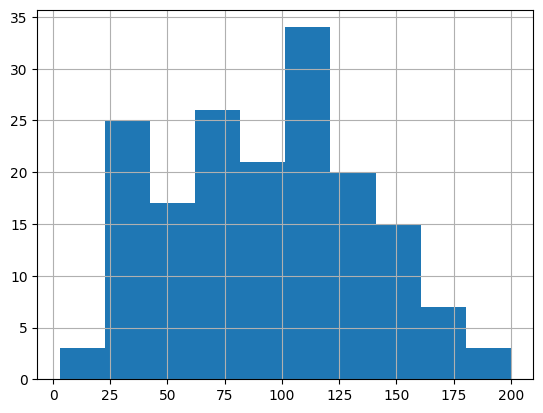

In [80]:
print(actual_df["capacity_mw"].sum())
actual_df["capacity_mw"].hist()

In [81]:
median_cap_df = actual_df.loc[actual_df["capacity_mw"] == actual_df["capacity_mw"].median()]
median_cap_df

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
11714,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
11723,az,Actual_34.85_-110.75_2006_UPV_100MW_5_Min.csv,Actual,34.85,-110.75,2006,UPV,100.0,5
11725,az,Actual_33.05_-111.75_2006_UPV_100MW_5_Min.csv,Actual,33.05,-111.75,2006,UPV,100.0,5
11729,az,Actual_33.95_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.95,-114.15,2006,UPV,100.0,5
11741,az,Actual_35.75_-114.65_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.65,2006,UPV,100.0,5
11758,az,Actual_34.15_-113.05_2006_UPV_100MW_5_Min.csv,Actual,34.15,-113.05,2006,UPV,100.0,5
11777,az,Actual_34.55_-114.25_2006_UPV_100MW_5_Min.csv,Actual,34.55,-114.25,2006,UPV,100.0,5
11787,az,Actual_33.65_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.65,-114.15,2006,UPV,100.0,5
11842,az,Actual_33.95_-113.85_2006_UPV_100MW_5_Min.csv,Actual,33.95,-113.85,2006,UPV,100.0,5
11857,az,Actual_35.75_-114.45_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.45,2006,UPV,100.0,5


In [90]:
# Just take the first median capacity plan
row = median_cap_df.iloc[0]
filename, state = row[FILENAME_COL], row[STATE_COL]
df = pd.read_csv(f"{DATA_DIR}/{state}/{filename}")
df = df.rename(columns={"LocalTime": "local_time", "Power(MW)": "power_mw"})
df["local_time"] = pd.to_datetime(df["local_time"], format="%m/%d/%y %H:%M")
print(df.shape)
df.head()

(105120, 2)


,local_time,power_mw
0,2006-01-01 00:00:00,0.0
1,2006-01-01 00:05:00,0.0
2,2006-01-01 00:10:00,0.0
3,2006-01-01 00:15:00,0.0
4,2006-01-01 00:20:00,0.0


In [92]:
df["power_mw"].describe()

count    105120.000000
mean         25.880631
std          31.626285
min           0.000000
25%           0.000000
50%           0.000000
75%          61.800000
max          99.900000
Name: power_mw, dtype: float64

In [93]:
day_df = df.loc[df["local_time"].dt.date == datetime.date(2006, 1, 1)]
day_df.shape

(288, 2)

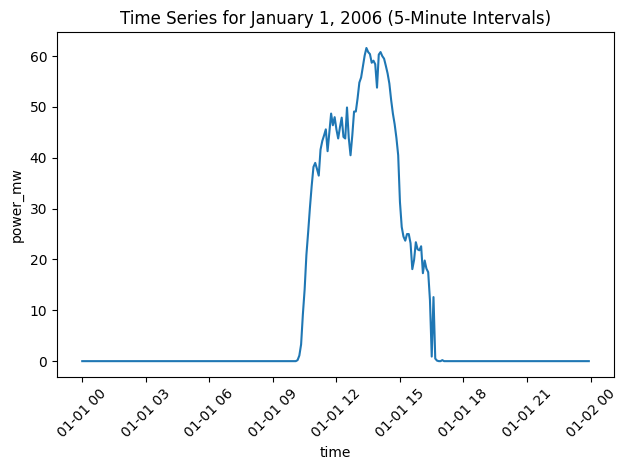

In [98]:
plt.plot(day_df['local_time'], day_df['power_mw'])
plt.title('Time Series for January 1, 2006 (5-Minute Intervals)')
plt.xlabel('time')
plt.ylabel('power_mw')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [99]:
df['date'] = df['local_time'].dt.date
df['time'] = df['local_time'].dt.strftime('%H:%M')
df.head()

,local_time,power_mw,date,time
0,2006-01-01 00:00:00,0.0,2006-01-01,00:00
1,2006-01-01 00:05:00,0.0,2006-01-01,00:05
2,2006-01-01 00:10:00,0.0,2006-01-01,00:10
3,2006-01-01 00:15:00,0.0,2006-01-01,00:15
4,2006-01-01 00:20:00,0.0,2006-01-01,00:20


In [100]:
df_pivot = df.pivot(index='time', columns='date', values='power_mw')
df_pivot.head()

date,2006-01-01,2006-01-02,2006-01-03,2006-01-04,2006-01-05,2006-01-06,2006-01-07,2006-01-08,2006-01-09,2006-01-10,...,2006-12-22,2006-12-23,2006-12-24,2006-12-25,2006-12-26,2006-12-27,2006-12-28,2006-12-29,2006-12-30,2006-12-31
time,,,,,,,,,,,,,,,,,,,,,
00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


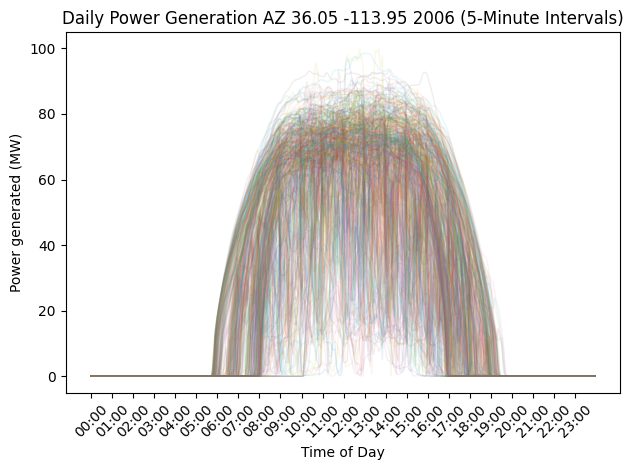

In [106]:
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], alpha=0.1, linewidth=1)

plt.title(f'Daily Power Generation {row[STATE_COL].upper()} {row["latitude"]} {row["longitude"]} 2006 (5-Minute Intervals)')
plt.xlabel('Time of Day')
plt.ylabel('Power generated (MW)')
plt.xticks(df_pivot.index[::12], rotation=45)  # Show every 12th time (hourly)
plt.tight_layout()
plt.show()

In [107]:
df.head()

,local_time,power_mw,date,time
0,2006-01-01 00:00:00,0.0,2006-01-01,00:00
1,2006-01-01 00:05:00,0.0,2006-01-01,00:05
2,2006-01-01 00:10:00,0.0,2006-01-01,00:10
3,2006-01-01 00:15:00,0.0,2006-01-01,00:15
4,2006-01-01 00:20:00,0.0,2006-01-01,00:20


In [108]:
mean_util = df["power_mw"].mean() / row["capacity_mw"] * 100
print(f"{mean_util:.2f}%")

25.88%


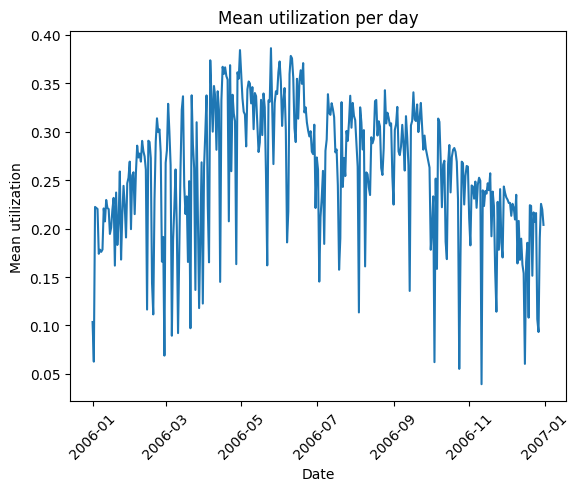

In [111]:
day_df = (df.groupby(by=["date"])["power_mw"].mean() / row["capacity_mw"]).reset_index()

plt.plot(day_df['date'], day_df['power_mw'])
plt.title('Mean utilization per day')
plt.xlabel('Date')
plt.ylabel('Mean utilization')
plt.xticks(rotation=45)
plt.show()

### Simulate utilization with batteries

Some questions to keep in mind
- Are we accounting for battery degradation?
- Where did the $200,000/MW assumption come from? How does it hold up to reality?
- TODO: run the experiment for a state by averaging all of it's plants

#### Given this solar plant, how would it perform for different battery capacities and loads?

In [131]:
sol = df["power_mw"] / row["capacity_mw"]

In [119]:
def uptime_with_battery(caps: list[float], loads: list[float], sol: list[float]) -> pd.DataFrame:
    """
    Simulates battery storage system to compute uptime and utilization.

    An assumption here is that load is constant, when in reality it fluctuates.
    It would be really cool to get a load data set to fill in the variability
    across each part of the day/year.

    Can also simulate as no battery system if caps are all zero.
    
    Parameters:
    caps: List of battery capacities (xWh).
    loads: List of load demands (xW).
    sol: Solar generation (xW) over time steps.

    Important thing here is that all parameters are in the same kW vs mW vs etc. unit.
    
    Returns:
    pd.DataFrame with the following columns:
        - Battery capacities
        - Load demands
        - Uptime (fraction of time battery is non-empty)
        - Utilization (fraction of load met)
    """
    # Initialize arrays
    caps = np.array(caps)
    loads = np.array(loads)
    sol = np.array(sol)
    n_steps = len(sol)
    n_caps = len(caps)
    n_loads = len(loads)
    time_step = 8760 / n_steps  # Time step in hours since capacity is in xWh
    
    # 3D array for battery state: [time steps, capacities, loads]
    batt = np.full((n_steps, n_caps, n_loads), caps[:, np.newaxis])
    
    # 3D array for utilization, initialized to zeros
    util = np.zeros_like(batt)
    
    # 2D matrices for loads and capacities
    loadsmat = np.tile(loads, (n_caps, 1))  # [caps, loads]
    capsmat = np.tile(caps[:, np.newaxis], (1, n_loads))  # [caps, loads]
    
    # Main loop over time steps
    for i in range(n_steps - 1):
        # Solar discretization: 1 if solar >= load, 0 otherwise
        # sundisc = 0.5 + 0.5 * np.sign(sol[i] - loadsmat)
        sundisc = (sol[i] >= loadsmat).astype(int)
        
        # Battery discharge discretization: 1 if battery can cover shortfall
        # Make sure that we don't accidentally add to battery if solar exceeds load
        # battdisc = 0.5 + 0.5 * np.sign(batt[i] - time_step * (loadsmat - sol[i]))
        battdisc = (batt[i] >= time_step * np.maximum(loadsmat - sol[i], 0.)).astype(int)
        
        # Utilization update
        util[i] = (sundisc + 
                   (1 - sundisc) * battdisc + 
                   (1 - sundisc) * (1 - battdisc) * 
                   (sol[i] / loadsmat + batt[i] / (time_step * loadsmat)))
        
        # Battery state update
        batt[i + 1] = (sundisc * (batt[i] + time_step * (sol[i] - loadsmat)) + 
                       (1 - sundisc) * battdisc * (batt[i] - time_step * (loadsmat - sol[i])) + 
                       (1 - sundisc) * (1 - battdisc) * 0.) # 0 case here just to explicitly show else clause

        # Apply capacity constraint
        # NOTE: important difference between this and reference,
        # we need to compute capdisc on the next battery state not the current.
        # This fixes a bug where we get "uptime" even when we pass in
        # a battery with capacity 0.
        batt[i + 1] = np.minimum(batt[i + 1], capsmat)

    # Compute uptime (fraction of time battery is non-empty)
    uptime = np.mean(np.sign(batt), axis=0)
    
    # Compute utilization (fraction of load met)
    utilization = np.mean(util, axis=0)
    
    # Create DataFrame
    # Flatten capsmat, loadsmat, uptime, and utilization for DataFrame
    caps_flat = capsmat.flatten()
    loads_flat = loadsmat.flatten()
    uptime_flat = uptime.flatten()
    utilization_flat = utilization.flatten()
    
    # Construct DataFrame
    df = pd.DataFrame({
        'capacity': caps_flat,
        'load': loads_flat,
        'uptime': uptime_flat,
        'utilization': utilization_flat
    })
    
    return df

no_battery_example = uptime_with_battery(np.array([0]), np.array([10]), np.array([20, 20]))
assert no_battery_example.iloc[0]["uptime"] == 0.

In [132]:
%%time
caps = np.array(list(range(5)))
loads = np.array(list(range(1, 5)))
result = uptime_with_battery(caps, loads, sol)
print(result.shape)
result.loc[:8]

(20, 4)
CPU times: user 2.26 s, sys: 21 ms, total: 2.28 s
Wall time: 2.28 s


,capacity,load,uptime,utilization
0,0,1,0.000000,0.000000
1,0,2,0.000000,0.000000
2,0,3,0.000000,0.000000
3,0,4,0.000000,0.000000
4,1,1,0.000010,0.000010
5,1,2,0.000010,0.000010
6,1,3,0.000010,0.000010
7,1,4,0.000010,0.000010
8,2,1,0.000019,0.000019


In [133]:
def uptime_with_battery_with_inputs(load: float, battery_sizes: list[float], array_sizes: list[float], sol: list[float]) -> pd.DataFrame:
    """
    Simulates battery storage system to compute uptime and utilization.

    Here load is a normalization parameter, i.e. `sol` is assumed to be normalized
    to `load` MW, and we can compute uptime and utilization of many battery +
    array sizes, without having to simulate many scaled versions of `sol`.
    I think there is a more intuitive way to write this (especially given
    we're in python land and not mathematica, but I haven't gotten around
    to it.

    An assumption here is that load is constant throughout a sim, when in
    reality it fluctuates. It would be really cool to get a load data set to fill
    in the variability across each part of the day/year.

    Can also simulate as no battery system if battery_sizes are zero.
    
    Parameters:
    battery_sizes: List of battery capacities (xWh).
    array_sizes: List of solar array sizes (xW).
    sol: Solar generation (xW) over time steps.

    Important thing here is that all parameters are in the same kW vs mW vs etc. unit.
    
    Returns:
    pd.DataFrame with the following columns:
        - Battery capacities
        - Load demands
        - Uptime (fraction of time battery is non-empty)
        - Utilization (fraction of load met)
    """
    # Initialize arrays
    battery_sizes = np.array(battery_sizes)
    array_sizes = np.array(array_sizes)
    sol = np.array(sol)
    n_steps = len(sol)
    n_battery_sizes = len(battery_sizes)
    n_array_sizes = len(array_sizes)
    time_step = 8760 / n_steps  # Time step in hours since capacity is in xWh

    # 2D matrices for loads and capacities
    # Normalize by array_sizes to avoid scaling many sols for each array_size
    loadsmat = np.tile(load / array_sizes, (n_battery_sizes, 1))  # [caps, loads]
    capsmat = np.tile(battery_sizes[:, np.newaxis], (1, n_array_sizes)) / loadsmat  # [caps, loads]

    array_size_mat = np.tile(array_sizes, (n_battery_sizes, 1))  # [caps, loads]
    battery_size_mat = np.tile(battery_sizes[:, np.newaxis], (1, n_array_sizes))  # [caps, loads]

    # 3D array for battery state: [time steps, capacities, loads]
    batt = np.zeros((n_steps, n_battery_sizes, n_array_sizes))
    batt[0] = capsmat # Batteries start full
    
    # 3D array for utilization, initialized to zeros
    util = np.zeros_like(batt)
    
    # Main loop over time steps
    for i in range(n_steps - 1):
        # Solar discretization: 1 if solar >= load, 0 otherwise
        # sundisc = 0.5 + 0.5 * np.sign(sol[i] - loadsmat)
        sundisc = (sol[i] >= loadsmat).astype(int)
        
        # Battery discharge discretization: 1 if battery can cover shortfall
        # Make sure that we don't accidentally add to battery if solar exceeds load
        # battdisc = 0.5 + 0.5 * np.sign(batt[i] - time_step * (loadsmat - sol[i]))
        battdisc = (batt[i] >= time_step * np.maximum(loadsmat - sol[i], 0.)).astype(int)
        
        # Utilization update
        util[i] = (sundisc + 
                   (1 - sundisc) * battdisc + 
                   (1 - sundisc) * (1 - battdisc) * 
                   (sol[i] / loadsmat + batt[i] / (time_step * loadsmat)))
        
        # Battery state update
        batt[i + 1] = (sundisc * (batt[i] + time_step * (sol[i] - loadsmat)) + 
                       (1 - sundisc) * battdisc * (batt[i] - time_step * (loadsmat - sol[i])) + 
                       (1 - sundisc) * (1 - battdisc) * 0.) # 0 case here just to explicitly show else clause

        # Apply capacity constraint
        # NOTE: important difference between this and reference,
        # we need to compute capdisc on the next battery state not the current.
        # This fixes a bug where we get "uptime" even when we pass in
        # a battery with capacity 0.
        batt[i + 1] = np.minimum(batt[i + 1], capsmat)

    # Compute uptime (fraction of time battery is non-empty)
    uptime = np.mean(np.sign(batt), axis=0)
    
    # Compute utilization (fraction of load met)
    utilization = np.mean(util, axis=0)
    
    # Create DataFrame
    # Flatten capsmat, loadsmat, uptime, and utilization for DataFrame
    battery_size_flat = battery_size_mat.flatten()
    array_size_flat = array_size_mat.flatten()
    caps_flat = capsmat.flatten()
    loads_flat = loadsmat.flatten()
    uptime_flat = uptime.flatten()
    utilization_flat = utilization.flatten()
    
    # Construct DataFrame
    df = pd.DataFrame({
        'battery_size': battery_size_flat,
        'array_size': array_size_flat,
        'capacity': caps_flat,
        'load': loads_flat,
        'uptime': uptime_flat,
        'utilization': utilization_flat
    })
    
    return df

no_battery_example = uptime_with_battery_with_inputs(1, np.array([0]), np.array([10]), np.array([20, 20]))
assert no_battery_example.iloc[0]["uptime"] == 0.

In [134]:
uptime_with_battery_with_inputs(1, np.array([0, 10, 20]), np.array([0.2, 0.5, 1, 2]), sol)

,battery_size,array_size,capacity,load,uptime,utilization
0,0,0.2,0.0,5.0,0.000000,0.051761
1,0,0.5,0.0,2.0,0.000000,0.129403
2,0,1.0,0.0,1.0,0.000000,0.258806
3,0,2.0,0.0,0.5,0.000000,0.397848
4,10,0.2,2.0,5.0,0.000048,0.051807
5,10,0.5,5.0,2.0,0.000295,0.129689
6,10,1.0,10.0,1.0,0.001142,0.259948
7,10,2.0,20.0,0.5,0.478291,0.522179
8,20,0.2,4.0,5.0,0.000095,0.051853
9,20,0.5,10.0,2.0,0.000580,0.129974


#### How much would this cost (per "productivity")?

In [135]:
def all_in_system_cost_parallel(solarcost: float, batterycost: float, loadcost: float, load: float, batterysize: np.array, arraysize: np.array, sol: np.array) -> np.array:
    result = uptime_with_battery_with_inputs(load, batterysize, arraysize, sol)
    capacity = result["capacity"]
    load = result["load"]
    uptime = result["uptime"]
    utilization = result["utilization"]
    result["cost"] = (capacity * batterycost + solarcost + loadcost * load) / (load * utilization)
    return result

result = all_in_system_cost_parallel(200000, 200000, 5000000, 1, [10, 15], [1, 5], sol)
result

,battery_size,array_size,capacity,load,uptime,utilization,cost
0,10,1,10.0,1.0,0.001142,0.259948,2.769786e+07
1,10,5,50.0,0.2,1.000000,0.999990,5.600053e+07
2,15,1,15.0,1.0,0.001998,0.260519,3.147568e+07
3,15,5,75.0,0.2,1.000000,0.999990,8.100077e+07


In [136]:
%%time
all_in_system_cost_parallel(200000, 200000, 5000000, 1, list(range(10)), list(range(1, 11)), sol)

CPU times: user 1.87 s, sys: 54.5 ms, total: 1.92 s
Wall time: 1.95 s


,battery_size,array_size,capacity,load,uptime,utilization,cost
0,0,1,0.0,1.000000,0.0,0.258806,2.009225e+07
1,0,2,0.0,0.500000,0.0,0.397848,1.357302e+07
2,0,3,0.0,0.333333,0.0,0.422905,1.324175e+07
3,0,4,0.0,0.250000,0.0,0.434111,1.336063e+07
4,0,5,0.0,0.200000,0.0,0.440515,1.362043e+07
...,...,...,...,...,...,...,...
95,9,6,54.0,0.166667,1.0,0.999990,7.100068e+07
96,9,7,63.0,0.142857,1.0,0.999990,9.460090e+07
97,9,8,72.0,0.125000,1.0,0.999990,1.218012e+08
98,9,9,81.0,0.111111,1.0,0.999990,1.526015e+08


In [173]:
def find_minimum_system_cost_parallel(
    solarcost: float,
    batterycost: float,
    loadcost: float,
    load: float,
    sol: list[float]
) -> tuple[list[float], list[float], list[float], list[float], list[float]]:

    # Adjust these to trade runtime for granularity of optimization (or try to at least)
    steps = [10, 1, 0.1, 0.01]
    range_count = 10

    # TODO: this is pretty fast, and reasonably effective, but
    # it's not as easily adjustable as I'd hope, and I suspect
    # it may be suboptimal in some cases.
    battery_size = steps[0] * range_count / 2
    array_size = steps[0] * range_count / 2
    min_cost = 99999999999999
    best_row = None
    for step in steps:
        battery_sizes = np.array([max(x, 0) for x in list(np.arange(battery_size - step * range_count/2, battery_size + step * range_count/2 + step, step))])
        array_sizes = np.array([max(x, step/range_count) for x in list(np.arange(array_size - step * range_count/2, array_size + step * range_count/2 + step, step))])
        costs = all_in_system_cost_parallel(solarcost, batterycost, loadcost, load, battery_sizes, array_sizes, sol)
        best_rows = costs.loc[costs["cost"] == costs["cost"].min()]
        best_row = best_rows.iloc[0]
        assert best_row["cost"] <= min_cost
        min_cost = best_row["cost"]
        battery_size = best_row["battery_size"]
        array_size = best_row["array_size"]
        assert min_cost >= 0
    
    return (
        [solarcost, batterycost, loadcost],
        [array_size, battery_size, 1.0],
        [solarcost * array_size, batterycost * battery_size, loadcost],
        [solarcost * array_size + batterycost * battery_size, 
         solarcost * array_size + batterycost * battery_size + loadcost, 
         min_cost],
        best_row.drop(["battery_size", "array_size", "cost"], axis=0).to_list()
    )

In [172]:
%%time
result = find_minimum_system_cost_parallel(200_000, 200_000, 10_000, 1, sol)
result

CPU times: user 7.77 s, sys: 152 ms, total: 7.93 s
Wall time: 7.95 s


([200000, 200000, 10000],
 [np.float64(1.1999999999999997), np.float64(0.0), 1.0],
 [np.float64(239999.99999999994), np.float64(0.0), 10000],
 [np.float64(239999.99999999994),
  np.float64(249999.99999999994),
  np.float64(806338.8097974766)],
 [0.0, 0.8333333333333335, 0.0, 0.31004336757992706])

In [153]:
columns = ["solar cost $/MW", "battery cost $/MWh",
"load cost $/MW", "arraysize (MW)", "battery size (MWh)",
"load size (1 MW by definition)", "array cost $", "battery cost $",
"load cost $ (all normalized to 1 MW)", "total power system cost $",
"total system cost $", "total system cost per utilization",
"battery size relative to 1 MW array", "load size relative to 1 MW array",
"annual battery utilization", "annual load utilization"]
output_df = pd.DataFrame(columns=columns)
output_df.head()

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization


In [154]:
# Note: annual load utilization should never be > 0
pd.DataFrame([{col: res for col, res in zip(columns, sum(result, []))}])

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,10000,1.195,0.0,1.0,239000.0,0.0,10000,239000.0,249000.0,806336.339096,0.0,0.83682,0.0,0.308804


In [169]:
%%time
for i in np.arange(0, 4.1, 0.1):
    result = find_minimum_system_cost_parallel(200_000, 200_000, 10_000 * 10 ** i, 1, sol)
    new_result = sum(result, [])
    output_df = pd.concat([output_df, pd.DataFrame([{col: res for col, res in zip(columns, new_result)}])])
    print("Finished:", i)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.] [ 0.05  1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
 12.   13.   14.   15.   16.   17.   18.   19.   20.  ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7
 0.8 0.9 1. ] [0.005 0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
 1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.   ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.02 0.03
 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ] [1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23
 1.24 1.25 1.26 1.27 1.28 1.29 1.3  1.31]
Finished: 0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.] [ 0.05  1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
 12.   13.   14.   15.   16.   17.   18.   19.   20.  ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7
 0.8 0.9 1. ] [0.005 0.1   0.2   0.3   0.4   0.5  

In [147]:
output_df

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,1.000000e+04,1.20,0.00,1.0,240000.0,0.0,1.000000e+04,240000.0,2.500000e+05,8.063388e+05,0.0000,0.833333,0.000000,0.310043
0,200000,200000,1.258925e+04,1.21,0.00,1.0,242000.0,0.0,1.258925e+04,242000.0,2.545893e+05,8.146627e+05,0.0000,0.826446,0.000000,0.312509
0,200000,200000,1.584893e+04,1.22,0.00,1.0,244000.0,0.0,1.584893e+04,244000.0,2.598489e+05,8.250454e+05,0.0000,0.819672,0.000000,0.314951
0,200000,200000,1.995262e+04,1.24,0.00,1.0,248000.0,0.0,1.995262e+04,248000.0,2.679526e+05,8.379739e+05,0.0000,0.806452,0.000000,0.319762
0,200000,200000,2.511886e+04,1.25,0.00,1.0,250000.0,0.0,2.511886e+04,250000.0,2.751189e+05,8.540758e+05,0.0000,0.800000,0.000000,0.322125
0,200000,200000,3.162278e+04,1.27,0.00,1.0,254000.0,0.0,3.162278e+04,254000.0,2.856228e+05,8.741252e+05,0.0000,0.787402,0.000000,0.326753
0,200000,200000,3.981072e+04,1.28,0.00,1.0,256000.0,0.0,3.981072e+04,256000.0,2.958107e+05,8.990973e+05,0.0000,0.781250,0.000000,0.329009
0,200000,200000,1.000000e+04,1.20,0.00,1.0,240000.0,0.0,1.000000e+04,240000.0,2.500000e+05,8.063388e+05,0.0000,0.833333,0.000000,0.310043
0,200000,200000,1.258925e+04,1.21,0.00,1.0,242000.0,0.0,1.258925e+04,242000.0,2.545893e+05,8.146627e+05,0.0000,0.826446,0.000000,0.312509
0,200000,200000,1.584893e+04,1.22,0.00,1.0,244000.0,0.0,1.584893e+04,244000.0,2.598489e+05,8.250454e+05,0.0000,0.819672,0.000000,0.314951


### North Texas Reference Output

In [149]:
pd.read_csv("reference/NorthTexas2.csv")

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,1.000000e+03,1.043255,0.000000,1.0,2.086510e+05,0.000000e+00,1.000000e+03,2.086510e+05,2.096510e+05,1.052468e+06,0.000000,0.958538,0.000048,0.199199
1,200000,200000,1.000000e+04,1.213295,0.000000,1.0,2.426591e+05,0.000000e+00,1.000000e+04,2.426591e+05,2.526591e+05,1.091915e+06,0.000000,0.824202,0.004100,0.231391
2,200000,200000,1.258925e+04,1.229319,0.000000,1.0,2.458638e+05,0.000000e+00,1.258925e+04,2.458638e+05,2.584531e+05,1.102941e+06,0.000000,0.813458,0.005251,0.234331
3,200000,200000,1.584893e+04,1.243668,0.000000,1.0,2.487337e+05,0.000000e+00,1.584893e+04,2.487337e+05,2.645826e+05,1.116665e+06,0.000000,0.804073,0.006516,0.236940
4,200000,200000,1.995262e+04,1.263295,0.000000,1.0,2.526591e+05,0.000000e+00,1.995262e+04,2.526591e+05,2.726117e+05,1.133707e+06,0.000000,0.791581,0.008847,0.240460
5,200000,200000,2.511886e+04,1.285518,0.000000,1.0,2.571037e+05,0.000000e+00,2.511886e+04,2.571037e+05,2.822226e+05,1.154932e+06,0.000000,0.777896,0.011406,0.244363
6,200000,200000,3.162278e+04,1.300120,0.000000,1.0,2.600240e+05,0.000000e+00,3.162278e+04,2.600240e+05,2.916467e+05,1.181372e+06,0.000000,0.769160,0.013813,0.246871
7,200000,200000,3.981072e+04,1.313181,0.000000,1.0,2.626363e+05,0.000000e+00,3.981072e+04,2.626363e+05,3.024470e+05,1.214296e+06,0.000000,0.761509,0.016210,0.249072
8,200000,200000,5.011872e+04,1.326388,0.000000,1.0,2.652776e+05,0.000000e+00,5.011872e+04,2.652776e+05,3.153964e+05,1.255334e+06,0.000000,0.753927,0.018997,0.251245
9,200000,200000,6.309573e+04,1.350757,0.000000,1.0,2.701514e+05,0.000000e+00,6.309573e+04,2.701514e+05,3.332471e+05,1.306283e+06,0.000000,0.740326,0.024524,0.255111


### Visualization

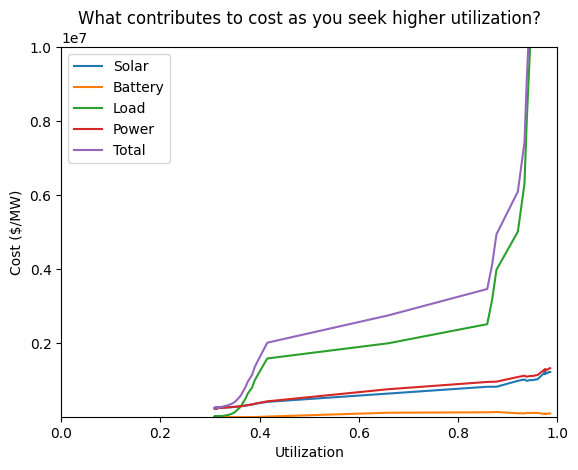

In [217]:
# What contributes to cost the most as you seek higher utilization?
utilization = output_df["annual load utilization"]
solar_cost = output_df["array cost $"]
battery_cost = output_df["battery cost $"]
load_cost = output_df["load cost $/MW"]
power_cost = output_df["total power system cost $"]
total_cost = output_df["total system cost $"]
plt.plot(utilization, solar_cost, label='Solar')
plt.plot(utilization, battery_cost, label='Battery')
plt.plot(utilization, load_cost, label='Load')
plt.plot(utilization, power_cost, label='Power')
plt.plot(utilization, total_cost, label='Total')

plt.title('What contributes to cost as you seek higher utilization?')
plt.xlabel('Utilization')
plt.ylabel('Cost ($/MW)')
# plt.yscale('log')
plt.xlim([0, 1])
plt.ylim([1 * 10 ** 4, 1 * 10 ** 7]) # Adjust per graph
plt.legend()
plt.show()

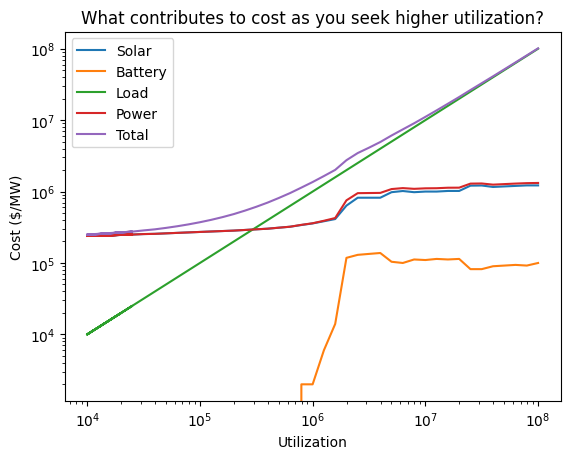

In [220]:
# What contributes to cost the most as you seek higher utilization?
solar_cost = output_df["array cost $"]
battery_cost = output_df["battery cost $"]
load_cost = output_df["load cost $/MW"]
power_cost = output_df["total power system cost $"]
total_cost = output_df["total system cost $"]
plt.plot(load_cost, solar_cost, label='Solar')
plt.plot(load_cost, battery_cost, label='Battery')
plt.plot(load_cost, load_cost, label='Load')
plt.plot(load_cost, power_cost, label='Power')
plt.plot(load_cost, total_cost, label='Total')

plt.title('What contributes to cost as you seek higher utilization?')
plt.xlabel('Utilization')
plt.ylabel('Cost ($/MW)')
plt.xscale('log')
plt.yscale('log')
# plt.xlim([0, 1])
# plt.ylim([1 * 10 ** 4, 1 * 10 ** 7]) # Adjust per graph
plt.legend()
plt.show()

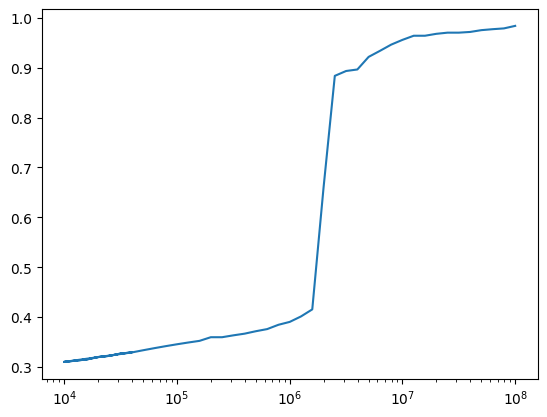

In [150]:
plt.plot(output_df["load cost $/MW"], output_df["annual load utilization"])
plt.xscale('log')